# Mécanisme d'attention
Dans ce notebook, nous allons explorer un problème de type *sequence-to-sequence*. Pour cela nous allons créer un jeu de donnée *jouet* (toy dataset) et l'analyser avec un réseau convolutif 1D. Nous comparerons les performances avant et après l'introduction d'une couche d'**attention**, ce qui nous permettra de comprendre la pertinence de ce mécanisme.

### imports python

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from io import open
import glob
import os
import matplotlib.pyplot as plt

## 1. Génération des données
On génère des sequences 1D contenant chacunes deux formes triangulaires et deux formes rectangulaires (step). La position et la hauteur de chacune des formes est choisie aléatoirement, la seule contrainte étant que les formes ne doivent pas se chevaucher.  
**L'objectif du notebook sera d'entrainer un modèle permettant de transformer un séquence de telle manière que les deux triangles et les deux rectangles fassent la même hauteur, respectivement.**  
[Source originale de l'exercice](https://fleuret.org/dlc/materials/dlc-handout-13-2-attention-mechanisms.pdf)

In [2]:
# hyperparamètres pour la génération
n_sequence = 1000 # nombres de séquences générées
n_points = 100 # nombre de points par séquence
width = 8 # largeur des triangles et step ajoutés dans les séquences

In [3]:
def make_shape(x, y, center, height, width=8, triangle=False):
    mask_up = (x <= center+width/2)
    mask_down = (x >= center-width/2)
    if triangle:
        y[mask_down & (x<=center)] = height * (x[mask_down & (x<=center)]-center+width/2) / 4
        y[mask_up & (x>center)] = height - height * (x[mask_up & (x>center)]-center) / 4
    else:
        y[mask_down & mask_up] = height
    return y

In [4]:
def difference_matrix(a):
    x = np.reshape(a, (len(a), 1))
    return x - x.transpose()

In [5]:
np.random.seed(42)

x_data = np.linspace(0, 100, 100)

s = 0
sequences_input = []
sequences_target_shape = [] # pour les parties 2 & 3
sequences_target_position = [] # pour la partie 4

while s < n_sequence:
    centers = np.sort(np.random.rand(4)*100) # génération aléatoire de la position des formes
    if centers.min()-width/2 < 0 or centers.max()+width/2 > 100:
        continue
    
    diff_matrix = np.abs(difference_matrix(centers))
    diag_mask = np.eye(diff_matrix.shape[0], diff_matrix.shape[1], dtype=bool)
    if diff_matrix[~diag_mask].min() >= width: # chevauchement ?
        s += 1
        heights = np.random.randint(2,29, 4) # génération aléatoire de la taille des formes
        triangle_idxs = np.random.choice(4, 2, replace=False) # choix aléatoire de la position des triangles
        mask_idx = np.zeros_like(heights).astype(bool)
        mask_idx[triangle_idxs] = True

        h_target_triangle = heights[mask_idx].mean() # cible = hauteur moyenne des triangles
        h_target_step = heights[~mask_idx].mean() # cible = hauteur moyenne des rectangle
        
        h_target_left = heights[:2].mean() # cible = hauteur moyenne des 2 formes les plus à gauche
        h_target_right = heights[2:].mean() # cible = hauteur moyenne des 2 formes les plus à droite

        seq = np.zeros_like(x_data)
        seq_target_shape = np.zeros_like(x_data)
        seq_target_position = np.zeros_like(x_data)
        for i, (c, h) in enumerate(zip(centers, heights)):
            if i in triangle_idxs:
                seq = make_shape(x_data, seq, c, h, triangle=True, width=width)
                seq_target_shape = make_shape(x_data, seq_target_shape, c, h_target_triangle, triangle=True, width=width)
                if i <2 :
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_left,
                                                     triangle=True, width=width)
                else:
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_right,
                                                     triangle=True, width=width)
            else:
                seq = make_shape(x_data, seq, c, h)
                seq_target_shape = make_shape(x_data, seq_target_shape, c, h_target_step)
                if i <2 :
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_left, width=width)
                else:
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_right, width=width)
                
        sequences_input.append(seq)
        sequences_target_shape.append(seq_target_shape)
        sequences_target_position.append(seq_target_position)
        
sequences_input = np.array(sequences_input).reshape(n_sequence, 1, 100)
sequences_target_shape = np.array(sequences_target_shape).reshape(n_sequence, 1, 100)
sequences_target_position = np.array(sequences_target_position).reshape(n_sequence, 1, 100)

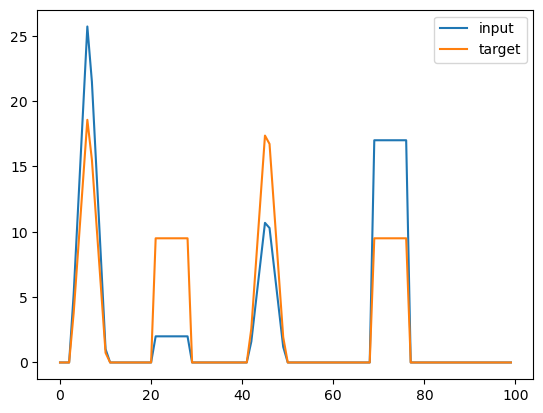

In [6]:
plt.plot(sequences_input[134,0], label='input')
plt.plot(sequences_target_shape[134,0], label='target')
plt.legend()

### Création des datasets pytorch

In [7]:
train_input, test_input, train_target, test_target = train_test_split(sequences_input,
                                                                      sequences_target_shape,
                                                                      test_size=0.25)

# Normalisation des données
mu, std = train_input.mean(), train_input.std()
train_input = (train_input-mu)/std
test_input = (test_input-mu)/std

# Conversion des tableaux numpy vers des tenseurs reconnus par pytorch :
train_input = torch.from_numpy(train_input).type(torch.FloatTensor)
train_target = torch.from_numpy(train_target).type(torch.FloatTensor)
train_data = TensorDataset(train_input, train_target)
print('dataset entrainement : ', train_data)

test_input = torch.from_numpy(test_input).type(torch.FloatTensor)
test_target = torch.from_numpy(test_target).type(torch.FloatTensor)
test_data = TensorDataset(test_input, test_target)
print('dataset entrainement : ', test_data)

dataset entrainement :  <torch.utils.data.dataset.TensorDataset object at 0x7fa778b578d0>
dataset entrainement :  <torch.utils.data.dataset.TensorDataset object at 0x7fa778a0f510>


## 2. Modèle sans mécanisme d'attention
**À faire** : Créer un modèle pytorch prenant en entrée une séquence et retournant en sortie une autre séquence, obtenue par l'application de 4 couches de convolution 1D, chacune composée de 64 convolutions de taille 5.  
On choisira un padding permettant de conserver la longeur originale des séquences et on appliquera une fonction d'activation ReLU après chaque convolution.

In [8]:
class Net_conv1d(nn.Module):
    def __init__(self):
        super(Net_conv1d, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 1, kernel_size=5, padding=2)            
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
model_conv1d = Net_conv1d()

### Entrainement

In [9]:
# Hyperparamètres
N_epochs = 100
learning_rate = 0.001
batch_size=50

n_iteration_per_epoch = len(train_input) // batch_size +1
n_test_loops = np.arange(0, N_epochs*n_iteration_per_epoch, n_iteration_per_epoch)

# Outil de chargement des données
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

**À faire** : choisir une fonction de coût pertinente pour le problème considéré.

In [ ]:
loss_function = nn.MSELoss()

In [10]:
def train_loop(model, optimizer, loss_function, train_loader, test_loader, N_epochs):
    losses = []   
    val_losses = []
    for epoch in range(N_epochs):  # Boucle sur les époques    
        for inputs, targets in train_loader:
            #Propagation en avant
            preds = model(inputs) # Equivalent à model.forward(features)

            #Calcul du coût
            loss = loss_function(preds, targets)

            #on sauvegarde la loss pour affichage futur
            losses.append(loss.item())

            #Effacer les gradients précédents
            optimizer.zero_grad()

            #Calcul des gradients (rétro-propagation)
            loss.backward()

            #Mise à jour des poids : un pas de l'optimiseur
            optimizer.step()
        print('Epoque',epoch, 'loss', loss.item())
        
        val_losses.append(test_loop(model, test_loader))

    print('Entrainement terminé')
    
    return losses, val_losses

def test_loop(model, test_loader):
    with torch.no_grad():
        val_loss = []
        for inputs, targets in test_loader:
            #Propagation en avant
            preds = model(inputs)

            #Calcul du coût
            loss = loss_function(preds, targets)

            #on sauvegarde la loss pour affichage futur
            val_loss.append(loss.item())
        
    return np.array(val_loss).mean()

def draw_loss(losses, val_losses, n_test_loops):
    # Afficher l'évolution de la fonction de coût
    fig, axes = plt.subplots(figsize=(8,6))
    axes.plot(losses,'r-',lw=2,label='Fonction de cout')
    axes.plot(n_test_loops, val_losses,'b-',lw=2,label='Fonction de cout - validation')
    axes.set_xlabel('N iterations',fontsize=18)
    axes.set_ylabel('Cout',fontsize=18)
    plt.yscale('log')
    plt.legend(loc='upper right',fontsize=16)

In [11]:
optimizer = optim.Adam(model_conv1d.parameters(), lr=learning_rate)
losses, val_losses = train_loop(model_conv1d, optimizer, loss_function, train_dataloader, test_dataloader, N_epochs)

Epoque 0 loss 17.077783584594727
Epoque 1 loss 11.492663383483887
Epoque 2 loss 8.610509872436523
Epoque 3 loss 6.708557605743408
Epoque 4 loss 6.217402935028076
Epoque 5 loss 4.778185844421387
Epoque 6 loss 4.576204776763916
Epoque 7 loss 4.0093913078308105
Epoque 8 loss 4.232690334320068
Epoque 9 loss 4.101901531219482
Epoque 10 loss 3.6982386112213135
Epoque 11 loss 3.7222793102264404
Epoque 12 loss 3.927825450897217
Epoque 13 loss 3.9173948764801025
Epoque 14 loss 3.7190895080566406
Epoque 15 loss 3.299232006072998
Epoque 16 loss 3.1422502994537354
Epoque 17 loss 3.3614323139190674
Epoque 18 loss 3.4906258583068848
Epoque 19 loss 3.183393955230713
Epoque 20 loss 3.4167356491088867
Epoque 21 loss 3.718871593475342
Epoque 22 loss 3.411534309387207
Epoque 23 loss 3.162461996078491
Epoque 24 loss 2.8452067375183105
Epoque 25 loss 3.7443151473999023
Epoque 26 loss 3.242003917694092
Epoque 27 loss 3.4287426471710205
Epoque 28 loss 3.4065465927124023
Epoque 29 loss 3.4052672386169434
Epoq

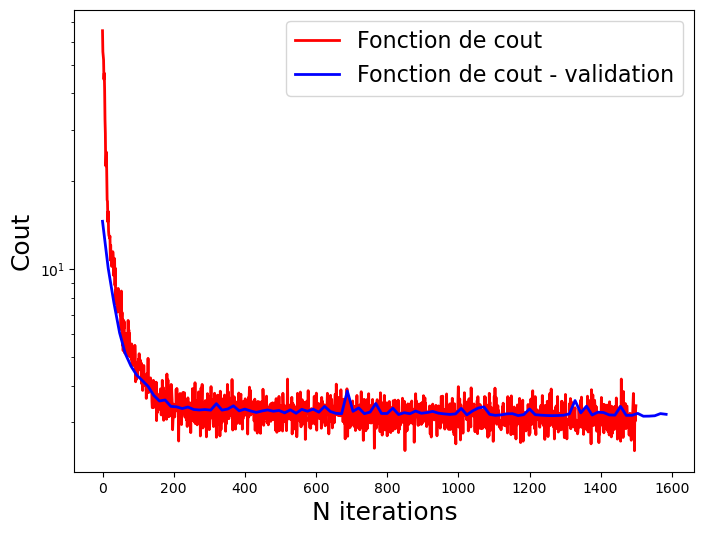

In [12]:
draw_loss(losses, val_losses, n_test_loops)

### Test

In [13]:
test_output_conv1d = model_conv1d(test_input)

In [14]:
print(f'Loss sur le dataset de test = {loss_function(test_output_conv1d, test_target):.3f}')

Loss sur le dataset de test = 3.196


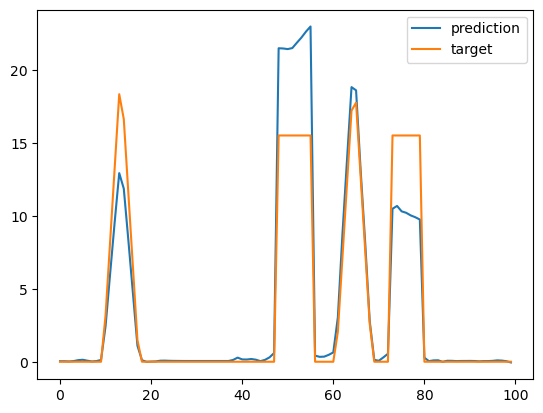

In [15]:
test_idx = 20

#plt.plot(test_input[test_idx,0].numpy()*std+mu, label='input')
plt.plot(test_output_conv1d[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target[test_idx,0].numpy(), label='target')
plt.legend()

## 3. Modèle avec couche d'attention

**À faire** : modifier le modèle défini plus haut en remplaçant la couche de convolution centrale par une couche d'attention.  
Rappel de la formule pour le mécanisme d'attention standard $$Y = \text{softmax} \left( QK^{T} \right) V $$  
On a les dimensions suivantes : $$ Q \in \mathcal{R}^{T\times D}, K \in \mathcal{R}^{T'\times D}, V \in \mathcal{R}^{T'\times D'} $$
où T (T') est la taille des séquences en entrée (sortie) de la couche d'attention, et D (D') est le nombre de *queries*/*keys* (*values*). Le nombre de *queries* et de *keys* doit correspondre, car les *queries* interrogent *keys*.  
D' correspond aussi au nombre de canaux en sortie.

In [16]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, key_dim):
        super().__init__()
        self.conv_Q = nn.Conv1d(in_dim, out_dim, kernel_size=1, bias=False)
        self.conv_K = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        self.conv_V = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        
    def forward(self, x, return_attention=False):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        
        A = torch.matmul(Q.transpose(1,2), K).softmax(2)
        y = torch.matmul(A, V.transpose(1,2)).transpose(1,2)
        if return_attention:
            return y, A
        else:
            return y

    
class Net_attention(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv_in = nn.Conv1d(in_channels, 64, kernel_size=5, padding=2)
        self.conv = nn.Conv1d(64, 64, kernel_size=5, padding=2)
        self.conv_out = nn.Conv1d(64, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.att = SelfAttentionLayer(64, 64, 64)
        
    def forward(self, x, return_attention=False):
        x = self.relu( self.conv_in(x) )
        x = self.relu( self.conv(x) )
        if return_attention:
            x, A = self.att(x, return_attention=True)
        else:
            x = self.att(x)
        x = self.relu( self.conv(x) )
        x = self.conv_out(x)
        if return_attention:
            return x, A
        else:
            return x
    
model_attention = Net_attention()

### Entrainement

In [17]:
optimizer = optim.Adam(model_attention.parameters(), lr=learning_rate)

losses, val_losses = train_loop(model_attention, optimizer, loss_function, train_dataloader, test_dataloader, N_epochs)

Epoque 0 loss 28.335487365722656
Epoque 1 loss 10.52829360961914
Epoque 2 loss 6.620064735412598
Epoque 3 loss 5.1171875
Epoque 4 loss 4.636999130249023
Epoque 5 loss 4.02082633972168
Epoque 6 loss 4.382424831390381
Epoque 7 loss 3.487783670425415
Epoque 8 loss 2.9479470252990723
Epoque 9 loss 2.21038556098938
Epoque 10 loss 2.6457560062408447
Epoque 11 loss 2.3193812370300293
Epoque 12 loss 2.5660009384155273
Epoque 13 loss 2.5528759956359863
Epoque 14 loss 2.277451992034912
Epoque 15 loss 2.1891844272613525
Epoque 16 loss 2.0013301372528076
Epoque 17 loss 2.2356719970703125
Epoque 18 loss 1.9833543300628662
Epoque 19 loss 2.065622329711914
Epoque 20 loss 2.136857748031616
Epoque 21 loss 1.7894927263259888
Epoque 22 loss 1.898147702217102
Epoque 23 loss 1.9995814561843872
Epoque 24 loss 1.8132388591766357
Epoque 25 loss 1.7025959491729736
Epoque 26 loss 1.4952573776245117
Epoque 27 loss 1.40800940990448
Epoque 28 loss 1.2720510959625244
Epoque 29 loss 1.2241884469985962
Epoque 30 loss

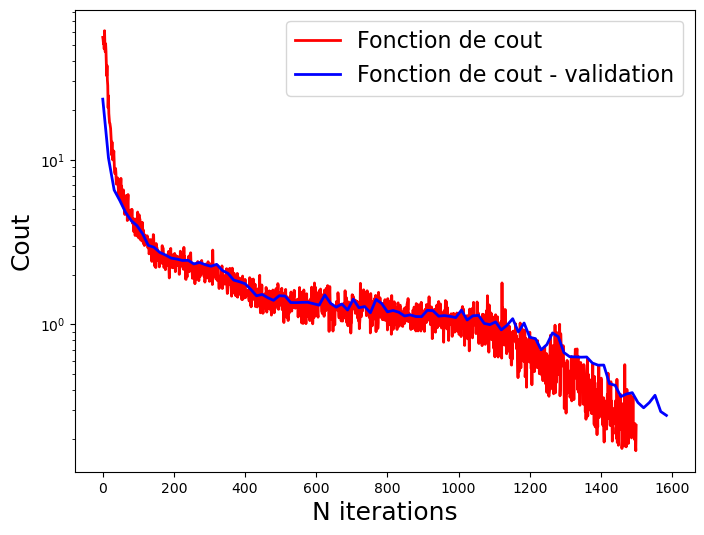

In [18]:
draw_loss(losses, val_losses, n_test_loops)

### Test

In [19]:
test_output_att = model_attention(test_input)

In [20]:
loss_function(test_output_att, test_target)

tensor(0.2782, grad_fn=<MseLossBackward0>)

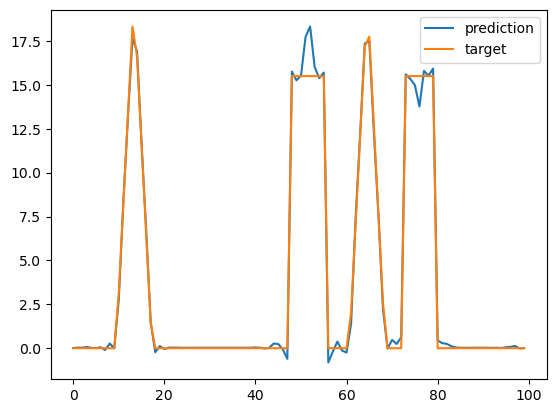

In [21]:
#plt.plot(test_input[10,0].numpy()*std+mu, label='input')
plt.plot(test_output_att[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target[test_idx,0].numpy(), label='target')
plt.legend()

### Visualisation de l'attention
On souhaite représenter la matrice d'attention (taille 100x100) pour une séquence de test.  
**À faire** : Modifier les classes `Net_attention` et `SelfAttentionLayer` afin qu'elles puissent retourner la matrice d'attention $$A = \text{softmax} \left( QK^{T} \right) $$ 

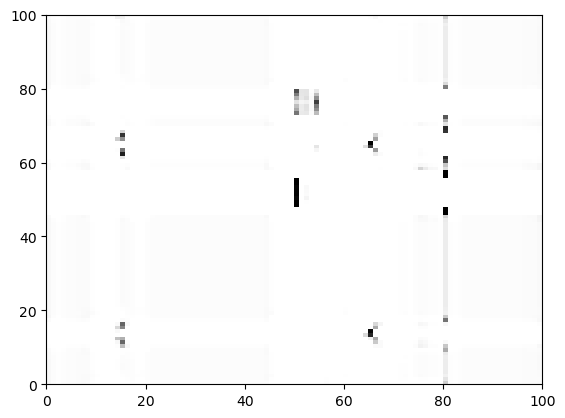

In [22]:
output, attention = model_attention(test_input[[test_idx]], return_attention=True)
plt.pcolor(attention.squeeze().detach().numpy(), cmap='gray_r')

## 4.Introduction au *positional encoding*
La couche d'attention définie au-dessus ne prend condidère aucunement la position des formes. On va introduire un nouvel objectif qui va dépendre de la position des formes afin d'illuster ici l'intérêt, et la nécessité, d'utiliser un *positional encoding* pour certaines tâches.

### Nouvelle tâche
Le nouvel objectif du réseau est de faire en sorte que les deux formes de gauche et les deux formes de droite aient la même hauteur, respectivement.

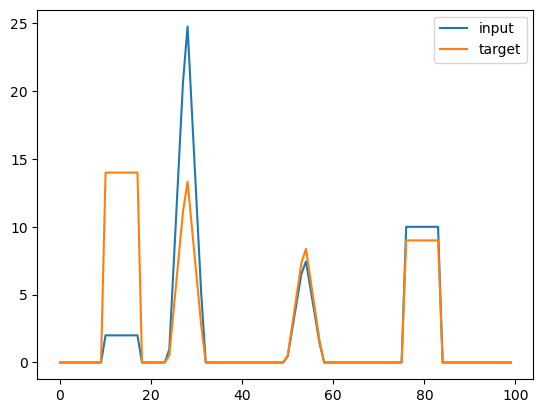

In [23]:
plt.plot(sequences_input[3,0], label='input')
plt.plot(sequences_target_position[3,0], label='target')
plt.legend()

On crée des nouveaux datasets et dataloaders avec les sequences cibles correspondant à la nouvelle tâche.

In [24]:
train_input_pos, test_input_pos, train_target_pos, test_target_pos = train_test_split(sequences_input,
                                                                      sequences_target_position,
                                                                      test_size=0.25)

# Normalisation des données
mu, std = train_input_pos.mean(), train_input_pos.std()
train_input_pos = (train_input_pos-mu)/std
test_input_pos = (test_input_pos-mu)/std

# Conversion des tableaux numpy vers des tenseurs reconnus par pytorch :
train_input_pos = torch.from_numpy(train_input_pos).type(torch.FloatTensor)
train_target_pos = torch.from_numpy(train_target_pos).type(torch.FloatTensor)
train_data_pos = TensorDataset(train_input_pos, train_target_pos)

test_input_pos = torch.from_numpy(test_input_pos).type(torch.FloatTensor)
test_target_pos = torch.from_numpy(test_target_pos).type(torch.FloatTensor)
test_data_pos = TensorDataset(test_input_pos, test_target_pos)

train_dataloader_pos = DataLoader(dataset=train_data_pos, batch_size=batch_size, shuffle=True)
test_dataloader_pos = DataLoader(dataset=test_data_pos, batch_size=batch_size, shuffle=False)

### Entrainement sans *positional encoding*

In [25]:
model_attention_noposition = Net_attention()

optimizer = optim.Adam(model_attention_noposition.parameters(), lr=learning_rate)
losses, val_losses = train_loop(model_attention_noposition, optimizer, loss_function, train_dataloader_pos, test_dataloader_pos, N_epochs)

Epoque 0 loss 22.0436954498291
Epoque 1 loss 10.191025733947754
Epoque 2 loss 7.998038291931152
Epoque 3 loss 6.4550933837890625
Epoque 4 loss 5.326747417449951
Epoque 5 loss 6.293229103088379
Epoque 6 loss 5.000398635864258
Epoque 7 loss 4.625160217285156
Epoque 8 loss 4.829275131225586
Epoque 9 loss 4.06020450592041
Epoque 10 loss 3.3348026275634766
Epoque 11 loss 3.27382230758667
Epoque 12 loss 3.2619004249572754
Epoque 13 loss 2.722777843475342
Epoque 14 loss 2.8852286338806152
Epoque 15 loss 3.0059001445770264
Epoque 16 loss 2.6233556270599365
Epoque 17 loss 2.555274724960327
Epoque 18 loss 2.8795440196990967
Epoque 19 loss 3.3709609508514404
Epoque 20 loss 2.397827386856079
Epoque 21 loss 3.608264923095703
Epoque 22 loss 2.9030044078826904
Epoque 23 loss 2.889737606048584
Epoque 24 loss 2.8404383659362793
Epoque 25 loss 2.944119930267334
Epoque 26 loss 2.9022982120513916
Epoque 27 loss 2.9199817180633545
Epoque 28 loss 2.9356844425201416
Epoque 29 loss 2.5435163974761963
Epoque 3

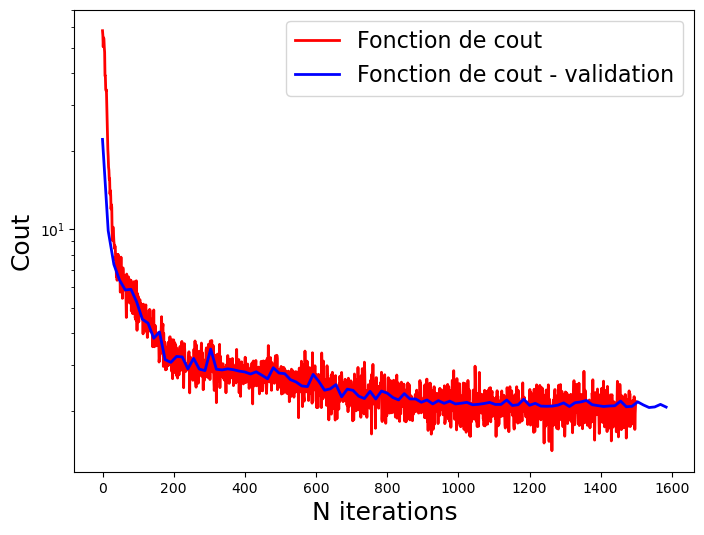

In [26]:
draw_loss(losses, val_losses, n_test_loops)

In [27]:
test_output_att_nopos = model_attention_noposition(test_input_pos)

In [28]:
loss_function(test_output_att_nopos, test_target_pos)

tensor(2.0690, grad_fn=<MseLossBackward0>)

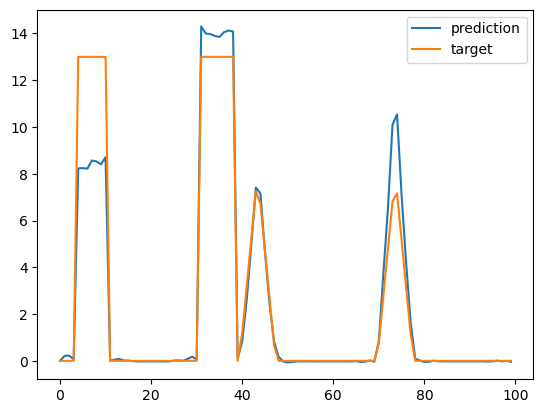

In [29]:
test_idx = 35

#plt.plot(test_input[10,0].numpy()*std+mu, label='input')
plt.plot(test_output_att_nopos[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target_pos[test_idx,0].numpy(), label='target')
plt.legend()

### Entrainement avec *positional encoding*
On va encoder en binaire la position de chaque point des séquences, puis concaténer cet encodage avec nos inputs.

In [30]:
def binary_positional_encoder(len_seq):
    c = np.ceil(np.log(len_seq) / np.log(2.0))
    o = 2**torch.arange(c).unsqueeze(1)
    pe = (torch.arange(len_seq).unsqueeze(0).div(o, rounding_mode = 'floor')) % 2
    return pe

**À faire** : créer le *positional encoding* correspondant aux séquences dans notre jeu de données.

In [31]:
pos_encoding = binary_positional_encoder(train_input_pos.shape[-1])

**À faire** : modifier les données d'entrainement et de test en concaténant chaque séquence d'input avec le *positional encoding* (même encodage pour toutes les séquences).  
Au final, pour un échantillon, on veux 8 canaux : 1 pour la séquence à proprement parler, et 7 additionels contenant le *positional encoding*.  
Au niveau des dimensions , on cherche à voir un tenseur de taille (N, 8, 100) suite à la concaténation, plutôt que (N, 1, 100) avant.

In [32]:
train_input_pe = torch.cat((train_input_pos, pos_encoding.expand(train_input_pos.shape[0],-1,-1)), dim=1)
test_input_pe = torch.cat((test_input_pos, pos_encoding.expand(test_input_pos.shape[0],-1,-1)), dim=1)

In [33]:
train_input_pe.shape

torch.Size([750, 8, 100])

In [34]:
train_data_pos = TensorDataset(train_input_pe, train_target_pos)

test_data_pos = TensorDataset(test_input_pe, test_target_pos)

train_dataloader_pos = DataLoader(dataset=train_data_pos, batch_size=batch_size, shuffle=True)
test_dataloader_pos = DataLoader(dataset=test_data_pos, batch_size=batch_size, shuffle=False)

In [35]:
model_attention_pe = Net_attention(in_channels=8)
optimizer = optim.Adam(model_attention_pe.parameters(), lr=learning_rate)
losses, val_losses = train_loop(model_attention_pe, optimizer, loss_function, train_dataloader_pos, test_dataloader_pos, N_epochs)

Epoque 0 loss 41.43126678466797
Epoque 1 loss 25.039243698120117
Epoque 2 loss 14.536118507385254
Epoque 3 loss 6.908336162567139
Epoque 4 loss 5.74337911605835
Epoque 5 loss 6.45341157913208
Epoque 6 loss 5.693824768066406
Epoque 7 loss 5.270770072937012
Epoque 8 loss 5.219146251678467
Epoque 9 loss 4.420834541320801
Epoque 10 loss 4.392083644866943
Epoque 11 loss 3.9506711959838867
Epoque 12 loss 3.6418616771698
Epoque 13 loss 4.2979326248168945
Epoque 14 loss 3.3440101146698
Epoque 15 loss 3.669496536254883
Epoque 16 loss 3.021629571914673
Epoque 17 loss 3.202131986618042
Epoque 18 loss 3.0620617866516113
Epoque 19 loss 3.285050868988037
Epoque 20 loss 2.813905954360962
Epoque 21 loss 2.96962571144104
Epoque 22 loss 2.9555022716522217
Epoque 23 loss 2.9308459758758545
Epoque 24 loss 3.347137212753296
Epoque 25 loss 3.348013162612915
Epoque 26 loss 3.6359148025512695
Epoque 27 loss 3.2701363563537598
Epoque 28 loss 2.91275691986084
Epoque 29 loss 2.745429515838623
Epoque 30 loss 2.82

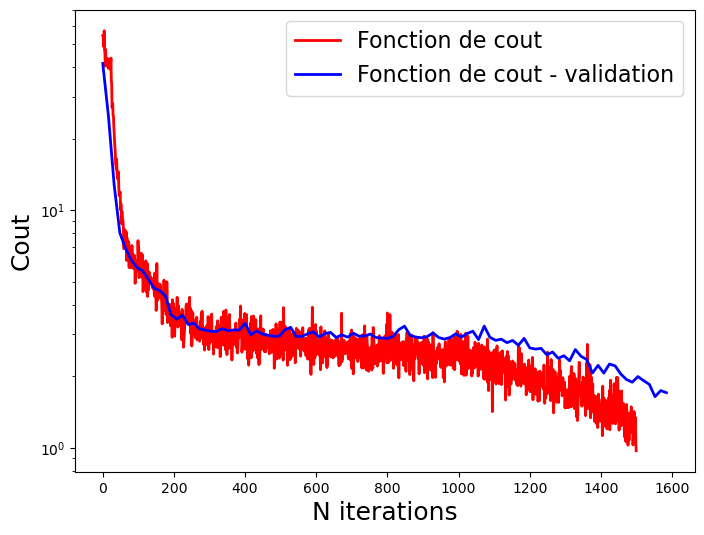

In [36]:
draw_loss(losses, val_losses, n_test_loops)

In [37]:
test_output_att_pos = model_attention_pe(test_input_pe)

In [38]:
loss_function(test_output_att_pos, test_target_pos)

tensor(1.7033, grad_fn=<MseLossBackward0>)

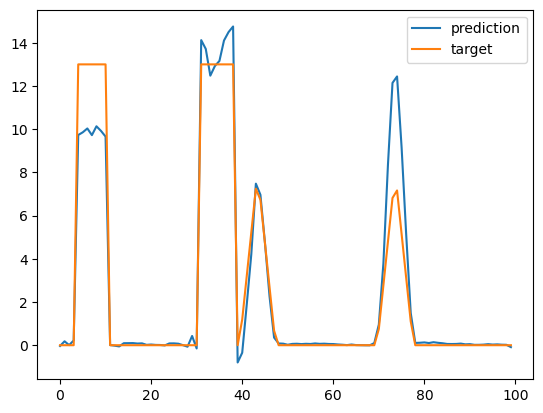

In [39]:
#plt.plot(test_input[10,0].numpy()*std+mu, label='input')
plt.plot(test_output_att_pos[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target_pos[test_idx,0].numpy(), label='target')
plt.legend()